In [1]:
import pandas as pd

def create_knowledge_graph(known_data_path, predictions_path, patents_path, output_nodes_path, output_edges_path):
    # Read the input files
    known_df = pd.read_csv(known_data_path)
    predictions_df = pd.read_csv(predictions_path)
    patents_df = pd.read_csv(patents_path)

    # Create nodes dataframe
    nodes = []
    
    # Add SMILES nodes
    smiles_set = set(known_df['SMILES'].unique()) | set(predictions_df['SMILES'].unique()) | set(patents_df['SMILES'].unique())
    nodes.extend([('SMILES', smiles) for smiles in smiles_set])
    
    # Add Functional Use nodes
    uses = set(known_df['Harmonized Functional Use'].dropna().unique())
    nodes.extend([('Functional_Use', use) for use in uses])
    
    # Add Predicted Use nodes
    pred_uses = set(predictions_df['Predicted_Use'].dropna().unique())
    nodes.extend([('Predicted_Use', use) for use in pred_uses])
    
    # Add Patent nodes
    patents = set(patents_df['Patent'].dropna().unique())
    nodes.extend([('Patent', patent) for patent in patents])
    
    # Add CPC nodes
    cpcs = set(patents_df['CPC_Code'].dropna().unique())
    nodes.extend([('CPC', cpc) for cpc in cpcs])
    
    # Add DTXSID nodes
    dtxsids = set(known_df['DTXSID'].dropna().unique())
    nodes.extend([('DTXSID', dtxsid) for dtxsid in dtxsids])
    
    # Create nodes DataFrame
    nodes_df = pd.DataFrame(nodes, columns=['type', 'id'])
    
    # Create edges
    edges = []
    
    # Add verified use edges
    for _, row in known_df.dropna(subset=['SMILES', 'Harmonized Functional Use']).iterrows():
        edges.append(('verified_use', row['SMILES'], row['Harmonized Functional Use']))
    
    # Add predicted use edges
    for _, row in predictions_df.dropna(subset=['SMILES', 'Predicted_Use']).iterrows():
        edges.append(('predicted_use', row['SMILES'], row['Predicted_Use']))
    
    # Add patent edges
    for _, row in patents_df.dropna(subset=['SMILES', 'Patent']).iterrows():
        edges.append(('appears_in_patent', row['SMILES'], row['Patent']))
    
    # Add CPC edges
    for _, row in patents_df.dropna(subset=['Patent', 'CPC_Code']).iterrows():
        edges.append(('has_cpc', row['Patent'], row['CPC_Code']))
    
    # Add DTXSID edges
    for _, row in known_df.dropna(subset=['SMILES', 'DTXSID']).iterrows():
        edges.append(('has_dtxsid', row['SMILES'], row['DTXSID']))
    
    # Create edges DataFrame
    edges_df = pd.DataFrame(edges, columns=['type', 'source', 'target'])
    
    # Save to CSV
    nodes_df.to_csv(output_nodes_path, index=False)
    edges_df.to_csv(output_edges_path, index=False)
    
    return nodes_df, edges_df

# Example usage:
if __name__ == "__main__":
    nodes_df, edges_df = create_knowledge_graph(
        '/home/matt/Proj/QSURv3/Data/Curated/UseCaseDataModeling.csv',
        '/home/matt/Proj/QSURv3/Results/Visualization/NNAnalysis/predictions_corrected.csv',
        '/home/matt/Proj/QSURv3/CPCProcessing/molecular_data_with_functions.csv',
        'nodes.csv',
        'edges.csv'
    )

/tmp/ipykernel_1196882/3168796759.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  known_df = pd.read_csv(known_data_path)


In [2]:
import pandas as pd
import networkx as nx
import random
from collections import Counter
import numpy as np

def analyze_large_knowledge_graph(nodes_path, edges_path, sample_size=10000):
    # Read nodes and edges in chunks
    print("Reading and analyzing data in chunks...")
    
    # Initialize counters
    node_type_counter = Counter()
    edge_type_counter = Counter()
    degree_counter = Counter()
    
    # Process nodes
    for chunk in pd.read_csv(nodes_path, chunksize=100000):
        node_type_counter.update(chunk['type'])
    
    # Process edges in chunks and maintain degree counts
    for chunk in pd.read_csv(edges_path, chunksize=100000):
        edge_type_counter.update(chunk['type'])
        # Update degree counts (source nodes)
        degree_counter.update(chunk['source'])
        # Update degree counts (target nodes)
        degree_counter.update(chunk['target'])
    
    # Basic statistics
    print("\nGraph Statistics:")
    print(f"Total number of nodes: {sum(node_type_counter.values())}")
    print(f"Total number of edges: {sum(edge_type_counter.values())}")
    
    print("\nNode type distribution:")
    for node_type, count in node_type_counter.most_common():
        print(f"{node_type}: {count}")
    
    print("\nEdge type distribution:")
    for edge_type, count in edge_type_counter.most_common():
        print(f"{edge_type}: {count}")
    
    # Analyze degree distribution
    degrees = list(degree_counter.values())
    print("\nDegree Statistics:")
    print(f"Average degree: {np.mean(degrees):.2f}")
    print(f"Median degree: {np.median(degrees):.2f}")
    print(f"Max degree: {max(degrees)}")
    
    # Sample a subgraph for more detailed analysis
    print("\nSampling subgraph for detailed analysis...")
    sampled_nodes = random.sample(list(degree_counter.keys()), min(sample_size, len(degree_counter)))
    
    # Read edges again to create sampled subgraph
    sampled_edges = []
    for chunk in pd.read_csv(edges_path, chunksize=100000):
        mask = (chunk['source'].isin(sampled_nodes)) & (chunk['target'].isin(sampled_nodes))
        sampled_edges.append(chunk[mask])
    
    sampled_edges_df = pd.concat(sampled_edges) if sampled_edges else pd.DataFrame()
    
    return {
        'node_distribution': dict(node_type_counter),
        'edge_distribution': dict(edge_type_counter),
        'degree_stats': {
            'mean': np.mean(degrees),
            'median': np.median(degrees),
            'max': max(degrees),
            'min': min(degrees)
        },
        'sampled_edges': sampled_edges_df
    }

def analyze_edge_patterns(edges_path, pattern_type, chunksize=100000):
    """
    Analyze specific patterns in edges (e.g., SMILES connections, patent connections)
    """
    pattern_counter = Counter()
    
    for chunk in pd.read_csv(edges_path, chunksize=chunksize):
        # Filter based on pattern type
        if pattern_type == 'SMILES':
            relevant_edges = chunk[chunk['type'].isin(['verified_use', 'predicted_use'])]
        elif pattern_type == 'patent':
            relevant_edges = chunk[chunk['type'].isin(['appears_in_patent', 'has_cpc'])]
        
        pattern_counter.update(relevant_edges['type'])
    
    return dict(pattern_counter)

# Example usage:
if __name__ == "__main__":
    # Basic analysis
    results = analyze_large_knowledge_graph('nodes.csv', 'edges.csv')
    
    # Pattern analysis
    smiles_patterns = analyze_edge_patterns('edges.csv', 'SMILES')
    patent_patterns = analyze_edge_patterns('edges.csv', 'patent')

Reading and analyzing data in chunks...

Graph Statistics:
Total number of nodes: 1755079
Total number of edges: 14644263

Node type distribution:
SMILES: 1686532
Patent: 48823
DTXSID: 10972
CPC: 8619
Functional_Use: 95
Predicted_Use: 38

Edge type distribution:
predicted_use: 8609969
appears_in_patent: 2879821
has_cpc: 2879821
verified_use: 137326
has_dtxsid: 137326

Degree Statistics:
Average degree: 16.69
Median degree: 1.00
Max degree: 2048121

Sampling subgraph for detailed analysis...


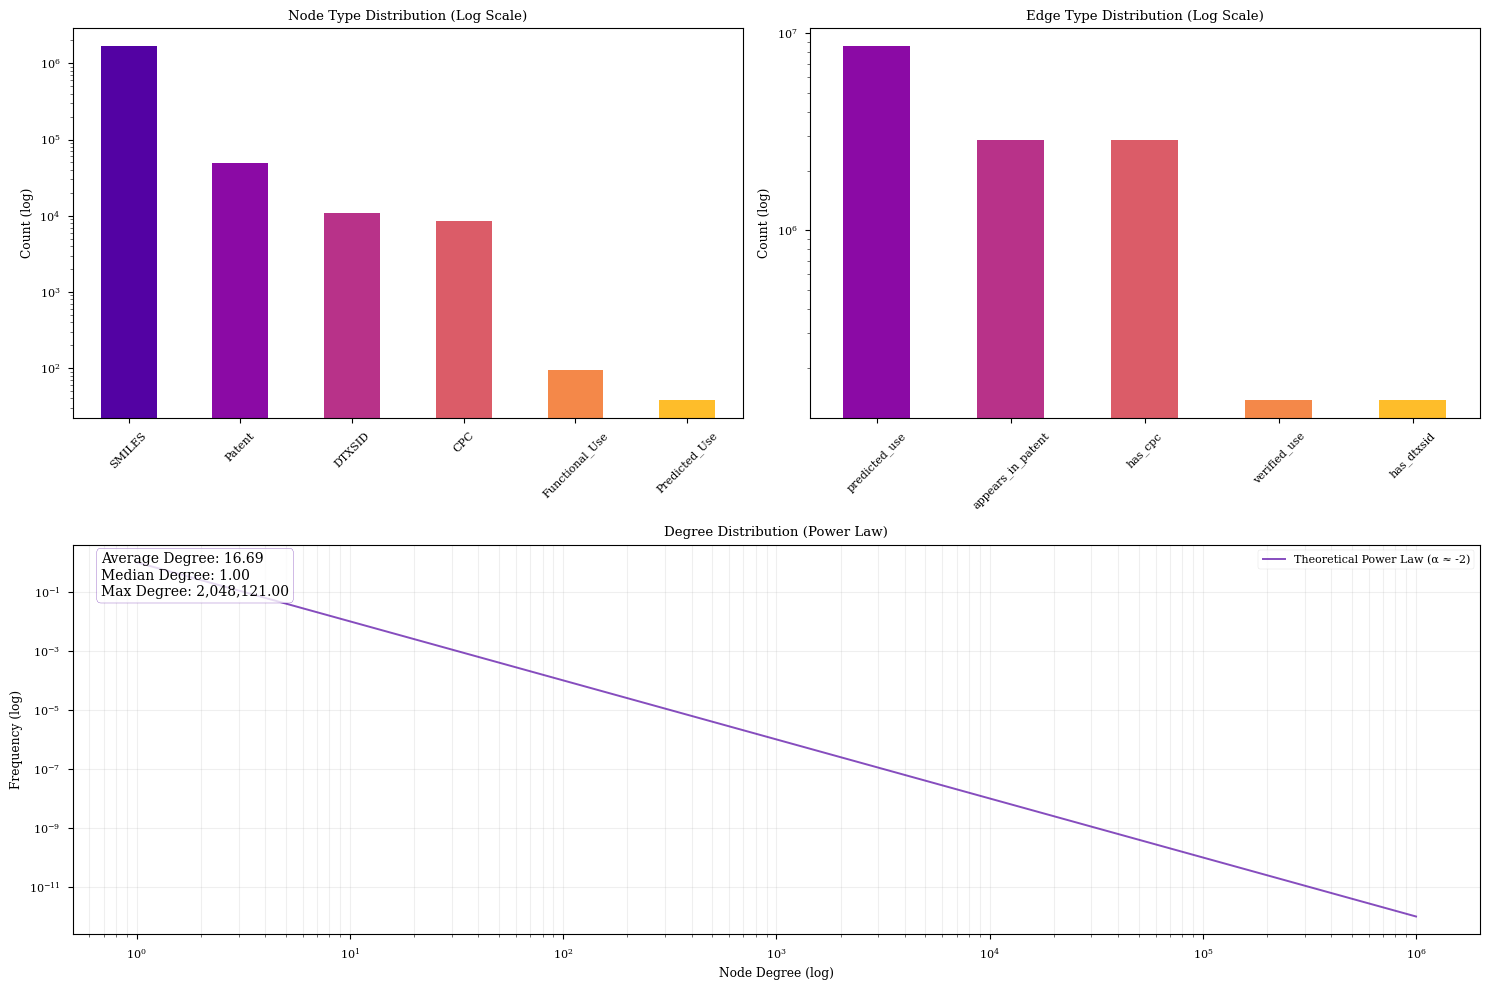

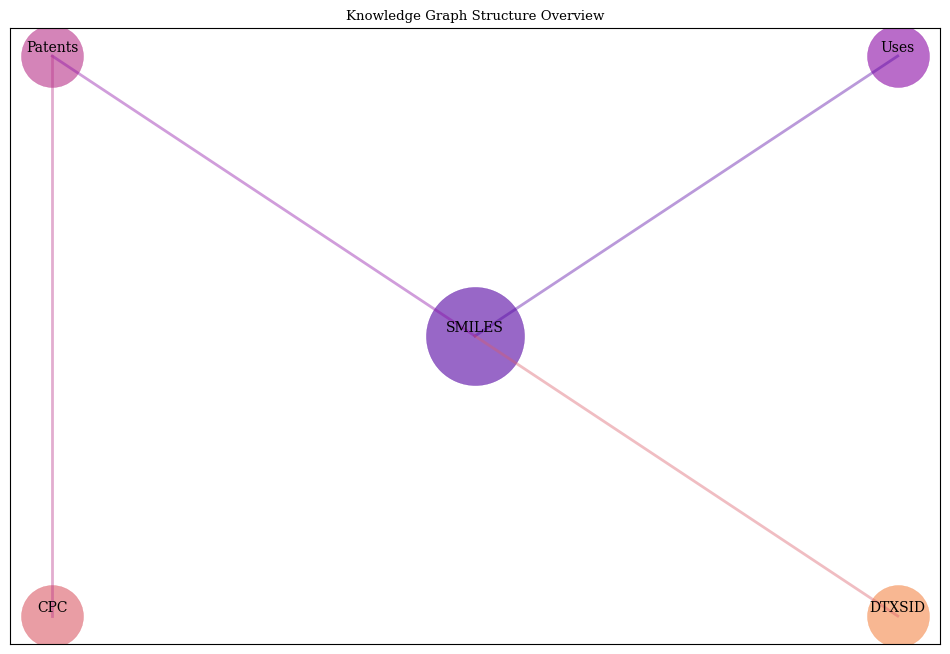

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec

def create_publication_visualizations():
    # Set style for publication
    plt.style.use('seaborn-v0_8-paper')
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.size'] = 10
    
    # Get plasma color palette
    plasma_colors = sns.color_palette("plasma", n_colors=6)
    
    # Node distribution data
    node_data = {
        'SMILES': 1686532,
        'Patent': 48823,
        'DTXSID': 10972,
        'CPC': 8619,
        'Functional_Use': 95,
        'Predicted_Use': 38
    }
    
    # Edge distribution data
    edge_data = {
        'predicted_use': 8609969,
        'appears_in_patent': 2879821,
        'has_cpc': 2879821,
        'verified_use': 137326,
        'has_dtxsid': 137326
    }
    
    # Create Figure 1: Summary Statistics
    fig1 = plt.figure(figsize=(15, 10))
    gs = GridSpec(2, 2, figure=fig1)
    
    # Plot 1: Node Distribution
    ax1 = fig1.add_subplot(gs[0, 0])
    nodes = pd.Series(node_data)
    bars1 = nodes.plot(kind='bar', ax=ax1, logy=True, color=plasma_colors)
    ax1.set_title('Node Type Distribution (Log Scale)')
    ax1.set_ylabel('Count (log)')
    ax1.tick_params(axis='x', rotation=45)
    
    # Plot 2: Edge Distribution
    ax2 = fig1.add_subplot(gs[0, 1])
    edges = pd.Series(edge_data)
    bars2 = edges.plot(kind='bar', ax=ax2, logy=True, color=plasma_colors[1:])
    ax2.set_title('Edge Type Distribution (Log Scale)')
    ax2.set_ylabel('Count (log)')
    ax2.tick_params(axis='x', rotation=45)
    
    # Plot 3: Degree Distribution
    ax3 = fig1.add_subplot(gs[1, :])
    degree_stats = {
        'Average Degree': 16.69,
        'Median Degree': 1.00,
        'Max Degree': 2048121
    }
    
    # Create theoretical power law distribution for comparison
    x = np.logspace(0, 6, 100)
    y = x**(-2)  # Power law with exponent -2
    
    # Plot power law in plasma color
    ax3.loglog(x, y, '-', color=plasma_colors[0], alpha=0.7, 
               label='Theoretical Power Law (α ≈ -2)')
    ax3.set_xlabel('Node Degree (log)')
    ax3.set_ylabel('Frequency (log)')
    ax3.set_title('Degree Distribution (Power Law)')
    ax3.grid(True, which="both", ls="-", alpha=0.2)
    ax3.legend()
    
    # Add degree statistics as text with nice background
    stats_text = '\n'.join([f'{k}: {v:,.2f}' for k, v in degree_stats.items()])
    ax3.text(0.02, 0.98, stats_text, transform=ax3.transAxes, 
             verticalalignment='top', 
             bbox=dict(boxstyle='round', facecolor='white', 
                      alpha=0.8, edgecolor=plasma_colors[0]))
    
    plt.tight_layout()
    plt.savefig('kg_summary_stats.png', dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    
    # Create Figure 2: Network Structure Overview
    fig2, ax = plt.subplots(figsize=(12, 8))
    
    # Create a simplified network visualization
    pos = {
        'SMILES': (0.5, 0.5),
        'Uses': (0.8, 0.8),
        'Patents': (0.2, 0.8),
        'CPC': (0.2, 0.2),
        'DTXSID': (0.8, 0.2)
    }
    
    # Draw nodes with plasma colors
    for i, (node, (x, y)) in enumerate(pos.items()):
        size = 5000 if node == 'SMILES' else 2000
        ax.scatter(x, y, s=size, alpha=0.6, label=node, 
                  color=plasma_colors[i])
        ax.text(x, y, f'{node}\n', ha='center', va='center', 
                color='black')
    
    # Draw edges with gradient colors
    for i, (start, end) in enumerate([
        ('SMILES', 'Uses'),
        ('SMILES', 'Patents'),
        ('Patents', 'CPC'),
        ('SMILES', 'DTXSID')
    ]):
        ax.plot([pos[start][0], pos[end][0]], 
                [pos[start][1], pos[end][1]], 
                '-', color=plasma_colors[i], alpha=0.4, linewidth=2)
    
    ax.set_title('Knowledge Graph Structure Overview')
    ax.set_xticks([])
    ax.set_yticks([])
    
    plt.savefig('kg_structure_overview.png', dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')

if __name__ == "__main__":
    create_publication_visualizations()

# for pub

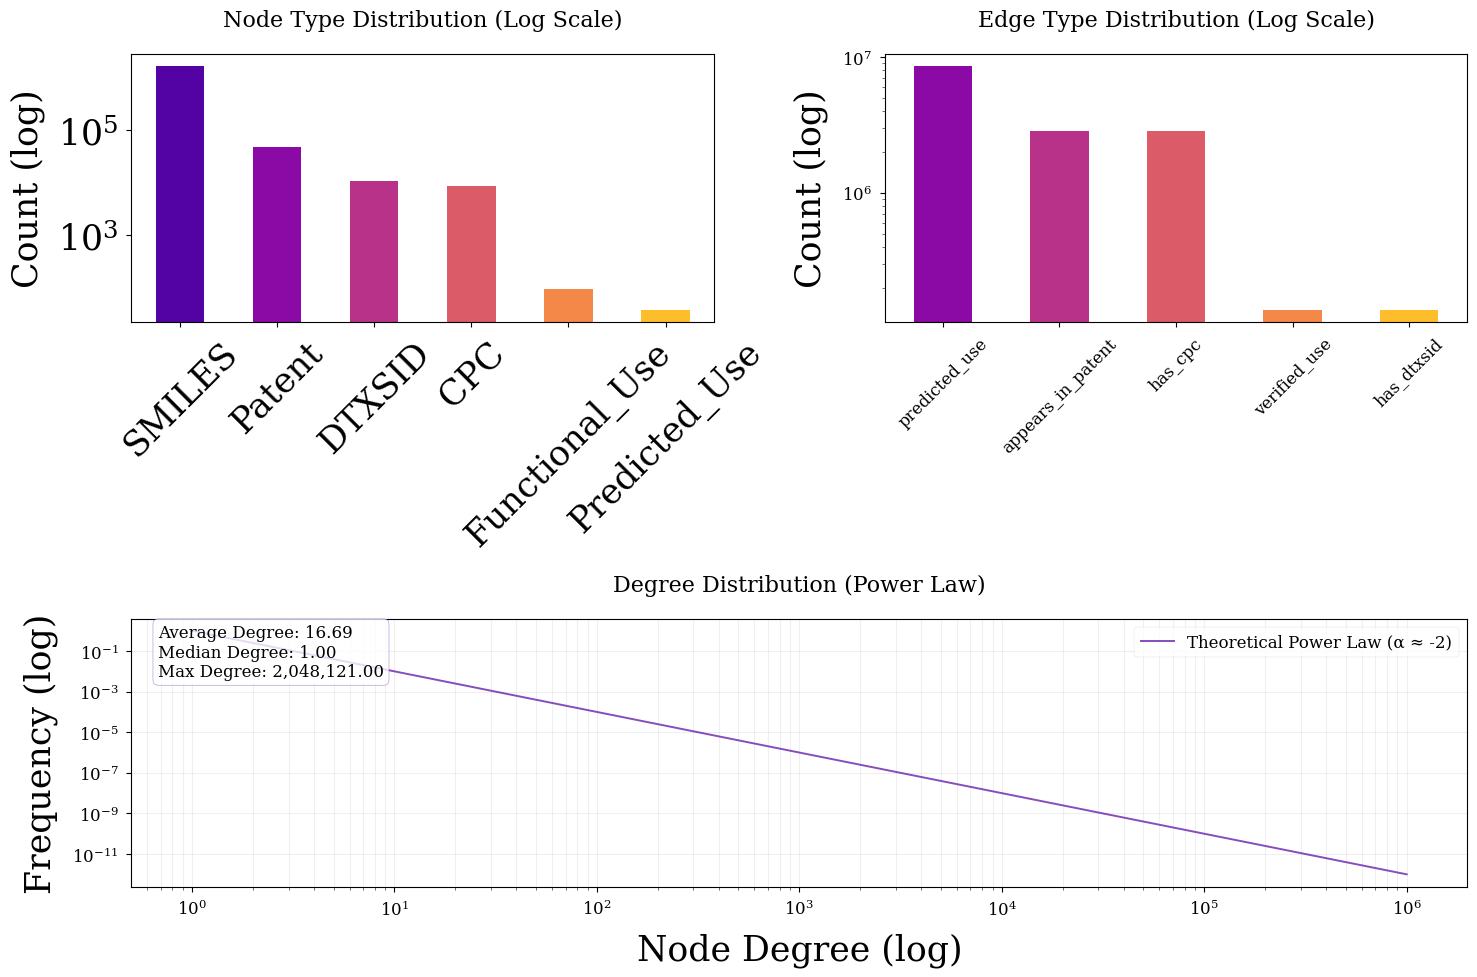

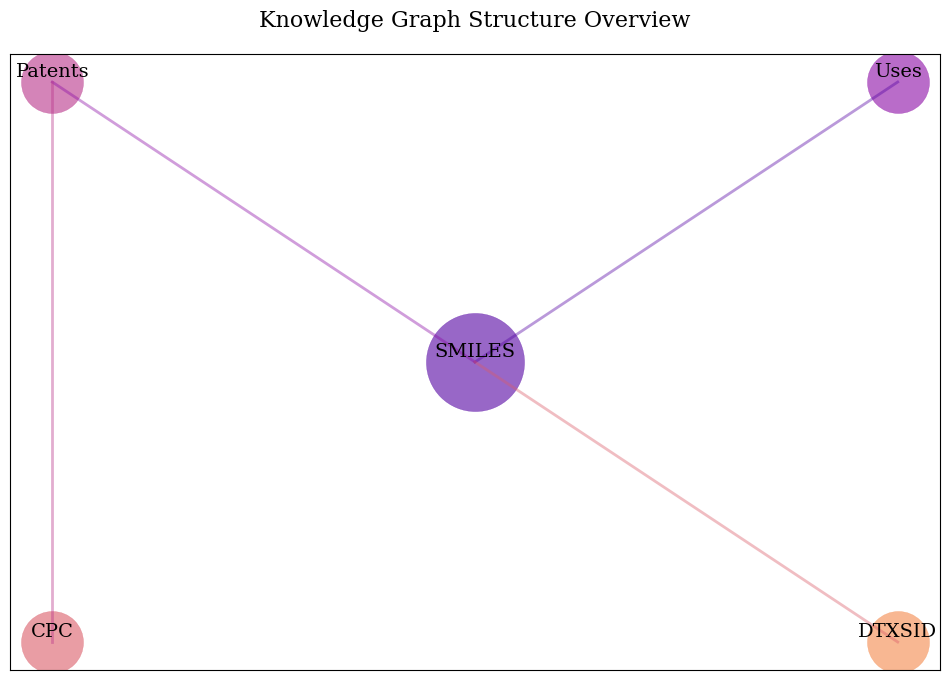

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec

def create_publication_visualizations():
    # Set style for publication with larger fonts
    plt.style.use('seaborn-v0_8-paper')
    plt.rcParams.update({
        'font.family': 'serif',
        'font.size': 14,  # Increased base font size
        'axes.titlesize': 16,  # Larger title size
        'axes.labelsize': 14,  # Larger label size
        'xtick.labelsize': 12,  # Larger tick labels
        'ytick.labelsize': 12,
        'legend.fontsize': 12,  # Larger legend text
    })
    
    # Get plasma color palette
    plasma_colors = sns.color_palette("plasma", n_colors=6)
    
    # Node distribution data
    node_data = {
        'SMILES': 1686532,
        'Patent': 48823,
        'DTXSID': 10972,
        'CPC': 8619,
        'Functional_Use': 95,
        'Predicted_Use': 38
    }
    
    # Edge distribution data
    edge_data = {
        'predicted_use': 8609969,
        'appears_in_patent': 2879821,
        'has_cpc': 2879821,
        'verified_use': 137326,
        'has_dtxsid': 137326
    }
    
    # Create Figure 1: Summary Statistics
    fig1 = plt.figure(figsize=(15, 10))
    gs = GridSpec(2, 2, figure=fig1)
    
    # Plot 1: Node Distribution
    ax1 = fig1.add_subplot(gs[0, 0])
    nodes = pd.Series(node_data)
    bars1 = nodes.plot(kind='bar', ax=ax1, logy=True, color=plasma_colors)
    ax1.set_title('Node Type Distribution (Log Scale)', fontsize=16, pad=20)
    ax1.set_ylabel('Count (log)', fontsize=25, labelpad=10)
    ax1.tick_params(axis='both', labelsize=25)
    ax1.tick_params(axis='x', rotation=45)
    
    # Plot 2: Edge Distribution
    ax2 = fig1.add_subplot(gs[0, 1])
    edges = pd.Series(edge_data)
    bars2 = edges.plot(kind='bar', ax=ax2, logy=True, color=plasma_colors[1:])
    ax2.set_title('Edge Type Distribution (Log Scale)', fontsize=16, pad=20)
    ax2.set_ylabel('Count (log)', fontsize=25, labelpad=10)
    ax2.tick_params(axis='both', labelsize=12)
    ax2.tick_params(axis='x', rotation=45)
    
    # Plot 3: Degree Distribution
    ax3 = fig1.add_subplot(gs[1, :])
    degree_stats = {
        'Average Degree': 16.69,
        'Median Degree': 1.00,
        'Max Degree': 2048121
    }
    
    x = np.logspace(0, 6, 100)
    y = x**(-2)
    
    ax3.loglog(x, y, '-', color=plasma_colors[0], alpha=0.7, 
               label='Theoretical Power Law (α ≈ -2)')
    ax3.set_xlabel('Node Degree (log)', fontsize=25, labelpad=10)
    ax3.set_ylabel('Frequency (log)', fontsize=25, labelpad=10)
    ax3.set_title('Degree Distribution (Power Law)', fontsize=16, pad=20)
    ax3.tick_params(axis='both', labelsize=12)
    ax3.grid(True, which="both", ls="-", alpha=0.2)
    ax3.legend(fontsize=12)
    
    # Add degree statistics as text with nice background
    stats_text = '\n'.join([f'{k}: {v:,.2f}' for k, v in degree_stats.items()])
    ax3.text(0.02, 0.98, stats_text, transform=ax3.transAxes, 
             verticalalignment='top', fontsize=12,  # Increased stats text size
             bbox=dict(boxstyle='round', facecolor='white', 
                      alpha=0.8, edgecolor=plasma_colors[0]))
    
    plt.tight_layout()
    plt.savefig('kg_summary_stats.png', dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    
    # Create Figure 2: Network Structure Overview
    fig2, ax = plt.subplots(figsize=(12, 8))
    
    pos = {
        'SMILES': (0.5, 0.5),
        'Uses': (0.8, 0.8),
        'Patents': (0.2, 0.8),
        'CPC': (0.2, 0.2),
        'DTXSID': (0.8, 0.2)
    }
    
    # Draw nodes with plasma colors
    for i, (node, (x, y)) in enumerate(pos.items()):
        size = 5000 if node == 'SMILES' else 2000
        ax.scatter(x, y, s=size, alpha=0.6, label=node, 
                  color=plasma_colors[i])
        ax.text(x, y, f'{node}\n', ha='center', va='center', 
                color='black', fontsize=14)  # Increased node label size
    
    # Draw edges with gradient colors
    for i, (start, end) in enumerate([
        ('SMILES', 'Uses'),
        ('SMILES', 'Patents'),
        ('Patents', 'CPC'),
        ('SMILES', 'DTXSID')
    ]):
        ax.plot([pos[start][0], pos[end][0]], 
                [pos[start][1], pos[end][1]], 
                '-', color=plasma_colors[i], alpha=0.4, linewidth=2)
    
    ax.set_title('Knowledge Graph Structure Overview', fontsize=16, pad=20)
    ax.set_xticks([])
    ax.set_yticks([])
    
    plt.savefig('kg_structure_overview.png', dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')

if __name__ == "__main__":
    create_publication_visualizations()

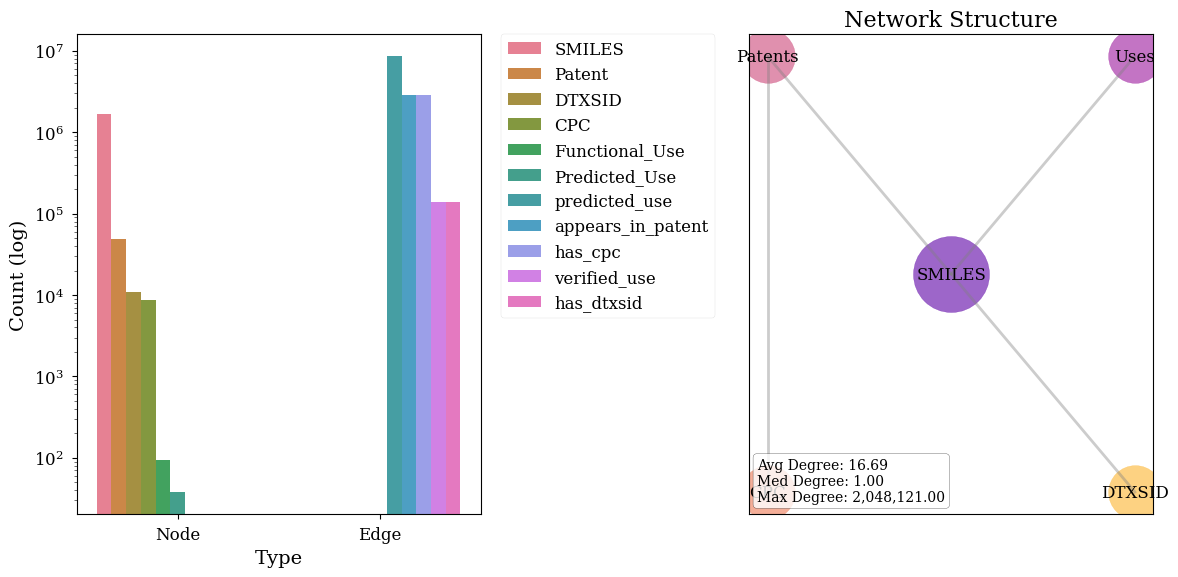

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec

def create_efficient_visualization():
    # Set style for publication
    plt.style.use('seaborn-v0_8-paper')
    plt.rcParams.update({
        'font.family': 'serif',
        'font.size': 14,
        'axes.titlesize': 16,
        'axes.labelsize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12,
    })
    
    # Combine all data into one dictionary with categories
    combined_data = {
        'Nodes': {
            'SMILES': 1686532,
            'Patent': 48823,
            'DTXSID': 10972,
            'CPC': 8619,
            'Functional_Use': 95,
            'Predicted_Use': 38
        },
        'Edges': {
            'predicted_use': 8609969,
            'appears_in_patent': 2879821,
            'has_cpc': 2879821,
            'verified_use': 137326,
            'has_dtxsid': 137326
        }
    }
    
    # Create a single figure with two subplots side by side
    fig = plt.figure(figsize=(12, 6))
    
    # Create subplot for the combined bar plot
    ax1 = plt.subplot(121)
    
    # Convert data to DataFrame for easier plotting
    df = pd.DataFrame({
        'Type': ['Node']*len(combined_data['Nodes']) + ['Edge']*len(combined_data['Edges']),
        'Name': list(combined_data['Nodes'].keys()) + list(combined_data['Edges'].keys()),
        'Count': list(combined_data['Nodes'].values()) + list(combined_data['Edges'].values())
    })
    
    # Create color palette
    colors = sns.color_palette("plasma", n_colors=2)
    
    # Create grouped bar plot
    sns.barplot(data=df, x='Type', y='Count', hue='Name', ax=ax1)
    ax1.set_yscale('log')
    ax1.set_ylabel('Count (log)')
    ax1.tick_params(axis='both', labelsize=12)
    
    # Rotate legend labels for better readability
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    # Create network structure overview
    ax2 = plt.subplot(122)
    
    # Simplified network visualization
    pos = {
        'SMILES': (0.5, 0.5),
        'Uses': (0.8, 0.8),
        'Patents': (0.2, 0.8),
        'CPC': (0.2, 0.2),
        'DTXSID': (0.8, 0.2)
    }
    
    # Draw nodes
    node_colors = sns.color_palette("plasma", n_colors=len(pos))
    for i, (node, (x, y)) in enumerate(pos.items()):
        size = 3000 if node == 'SMILES' else 1500
        ax2.scatter(x, y, s=size, alpha=0.6, color=node_colors[i])
        ax2.text(x, y, node, ha='center', va='center', fontsize=12)
    
    # Draw edges
    for start, end in [
        ('SMILES', 'Uses'),
        ('SMILES', 'Patents'),
        ('Patents', 'CPC'),
        ('SMILES', 'DTXSID')
    ]:
        ax2.plot([pos[start][0], pos[end][0]], 
                [pos[start][1], pos[end][1]], 
                '-', color='gray', alpha=0.4, linewidth=2)
    
    ax2.set_title('Network Structure')
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    # Add degree statistics as text box
    degree_stats = {
        'Avg Degree': 16.69,
        'Med Degree': 1.00,
        'Max Degree': 2048121
    }
    stats_text = '\n'.join([f'{k}: {v:,.2f}' for k, v in degree_stats.items()])
    ax2.text(0.02, 0.02, stats_text, transform=ax2.transAxes, 
             verticalalignment='bottom', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('kg_efficient_summary.png', dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')

if __name__ == "__main__":
    create_efficient_visualization()

# new analysis 

In [5]:
import pandas as pd

def create_knowledge_graph(known_data_path, predictions_path, patents_path, output_nodes_path, output_edges_path):
    # Read the input files
    known_df = pd.read_csv(known_data_path)
    predictions_df = pd.read_csv(predictions_path)
    patents_df = pd.read_csv(patents_path)

    # Create nodes dataframe (this part remains the same)
    nodes = []
    
    # Add SMILES nodes
    smiles_set = set(known_df['SMILES'].unique()) | set(predictions_df['SMILES'].unique()) | set(patents_df['SMILES'].unique())
    nodes.extend([('SMILES', smiles) for smiles in smiles_set])
    
    # Add other nodes (remains the same)
    uses = set(known_df['Harmonized Functional Use'].dropna().unique())
    nodes.extend([('Functional_Use', use) for use in uses])
    
    pred_uses = set(predictions_df['Predicted_Use'].dropna().unique())
    nodes.extend([('Predicted_Use', use) for use in pred_uses])
    
    patents = set(patents_df['Patent'].dropna().unique())
    nodes.extend([('Patent', patent) for patent in patents])
    
    cpcs = set(patents_df['CPC_Code'].dropna().unique())
    nodes.extend([('CPC', cpc) for cpc in cpcs])
    
    dtxsids = set(known_df['DTXSID'].dropna().unique())
    nodes.extend([('DTXSID', dtxsid) for dtxsid in dtxsids])
    
    # Create nodes DataFrame
    nodes_df = pd.DataFrame(nodes, columns=['type', 'id'])
    
    # Create edges with duplicate removal
    # Create edges using pandas operations instead of loops
    edges = []
    
    # Verified use edges
    verified_edges = known_df.dropna(subset=['SMILES', 'Harmonized Functional Use'])[['SMILES', 'Harmonized Functional Use']].drop_duplicates()
    edges.extend([('verified_use', row['SMILES'], row['Harmonized Functional Use']) 
                 for _, row in verified_edges.iterrows()])
    
    # Predicted use edges
    predicted_edges = predictions_df.dropna(subset=['SMILES', 'Predicted_Use'])[['SMILES', 'Predicted_Use']].drop_duplicates()
    edges.extend([('predicted_use', row['SMILES'], row['Predicted_Use']) 
                 for _, row in predicted_edges.iterrows()])
    
    # Patent edges
    patent_edges = patents_df.dropna(subset=['SMILES', 'Patent'])[['SMILES', 'Patent']].drop_duplicates()
    edges.extend([('appears_in_patent', row['SMILES'], row['Patent']) 
                 for _, row in patent_edges.iterrows()])
    
    # CPC edges
    cpc_edges = patents_df.dropna(subset=['Patent', 'CPC_Code'])[['Patent', 'CPC_Code']].drop_duplicates()
    edges.extend([('has_cpc', row['Patent'], row['CPC_Code']) 
                 for _, row in cpc_edges.iterrows()])
    
    # DTXSID edges
    dtxsid_edges = known_df.dropna(subset=['SMILES', 'DTXSID'])[['SMILES', 'DTXSID']].drop_duplicates()
    edges.extend([('has_dtxsid', row['SMILES'], row['DTXSID']) 
                 for _, row in dtxsid_edges.iterrows()])
    
    # Create edges DataFrame and remove any remaining duplicates
    edges_df = pd.DataFrame(edges, columns=['type', 'source', 'target'])
    edges_df = edges_df.drop_duplicates()
    
    # Print statistics before saving
    print("\nKnowledge Graph Statistics:")
    print(f"Total nodes: {len(nodes_df)}")
    print("\nNodes by type:")
    print(nodes_df['type'].value_counts())
    print("\nTotal edges: {len(edges_df)}")
    print("\nEdges by type:")
    print(edges_df['type'].value_counts())
    
    # Save to CSV
    nodes_df.to_csv(output_nodes_path, index=False)
    edges_df.to_csv(output_edges_path, index=False)
    
    return nodes_df, edges_df

In [6]:
# Example usage:
if __name__ == "__main__":
    nodes_df, edges_df = create_knowledge_graph(
        '/home/matt/Proj/QSURv3/Data/Curated/UseCaseDataModeling.csv',
        '/home/matt/Proj/QSURv3/Results/Visualization/NNAnalysis/predictions_corrected.csv',
        '/home/matt/Proj/QSURv3/CPCProcessing/molecular_data_with_functions.csv',
        'nodes.csv',
        'edges.csv'
    )

/tmp/ipykernel_1353972/3776272683.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  known_df = pd.read_csv(known_data_path)



Knowledge Graph Statistics:
Total nodes: 1755079

Nodes by type:
type
SMILES            1686532
Patent              48823
DTXSID              10972
CPC                  8619
Functional_Use         95
Predicted_Use          38
Name: count, dtype: int64

Total edges: {len(edges_df)}

Edges by type:
type
appears_in_patent    2879209
predicted_use         409999
has_cpc                48823
verified_use           20483
has_dtxsid             10972
Name: count, dtype: int64


In [7]:
import pandas as pd
import networkx as nx
import random
from collections import Counter
import numpy as np

def analyze_large_knowledge_graph(nodes_path, edges_path, sample_size=10000):
    # Read nodes and edges in chunks
    print("Reading and analyzing data in chunks...")
    
    # Initialize counters
    node_type_counter = Counter()
    edge_type_counter = Counter()
    degree_counter = Counter()
    
    # Process nodes
    for chunk in pd.read_csv(nodes_path, chunksize=100000):
        node_type_counter.update(chunk['type'])
    
    # Process edges in chunks and maintain degree counts
    for chunk in pd.read_csv(edges_path, chunksize=100000):
        edge_type_counter.update(chunk['type'])
        # Update degree counts (source nodes)
        degree_counter.update(chunk['source'])
        # Update degree counts (target nodes)
        degree_counter.update(chunk['target'])
    
    # Basic statistics
    print("\nGraph Statistics:")
    print(f"Total number of nodes: {sum(node_type_counter.values())}")
    print(f"Total number of edges: {sum(edge_type_counter.values())}")
    
    print("\nNode type distribution:")
    for node_type, count in node_type_counter.most_common():
        print(f"{node_type}: {count}")
    
    print("\nEdge type distribution:")
    for edge_type, count in edge_type_counter.most_common():
        print(f"{edge_type}: {count}")
    
    # Analyze degree distribution
    degrees = list(degree_counter.values())
    print("\nDegree Statistics:")
    print(f"Average degree: {np.mean(degrees):.2f}")
    print(f"Median degree: {np.median(degrees):.2f}")
    print(f"Max degree: {max(degrees)}")
    
    # Sample a subgraph for more detailed analysis
    print("\nSampling subgraph for detailed analysis...")
    sampled_nodes = random.sample(list(degree_counter.keys()), min(sample_size, len(degree_counter)))
    
    # Read edges again to create sampled subgraph
    sampled_edges = []
    for chunk in pd.read_csv(edges_path, chunksize=100000):
        mask = (chunk['source'].isin(sampled_nodes)) & (chunk['target'].isin(sampled_nodes))
        sampled_edges.append(chunk[mask])
    
    sampled_edges_df = pd.concat(sampled_edges) if sampled_edges else pd.DataFrame()
    
    return {
        'node_distribution': dict(node_type_counter),
        'edge_distribution': dict(edge_type_counter),
        'degree_stats': {
            'mean': np.mean(degrees),
            'median': np.median(degrees),
            'max': max(degrees),
            'min': min(degrees)
        },
        'sampled_edges': sampled_edges_df
    }

def analyze_edge_patterns(edges_path, pattern_type, chunksize=100000):
    """
    Analyze specific patterns in edges (e.g., SMILES connections, patent connections)
    """
    pattern_counter = Counter()
    
    for chunk in pd.read_csv(edges_path, chunksize=chunksize):
        # Filter based on pattern type
        if pattern_type == 'SMILES':
            relevant_edges = chunk[chunk['type'].isin(['verified_use', 'predicted_use'])]
        elif pattern_type == 'patent':
            relevant_edges = chunk[chunk['type'].isin(['appears_in_patent', 'has_cpc'])]
        
        pattern_counter.update(relevant_edges['type'])
    
    return dict(pattern_counter)

# Example usage:
if __name__ == "__main__":
    # Basic analysis
    results = analyze_large_knowledge_graph('nodes.csv', 'edges.csv')
    
    # Pattern analysis
    smiles_patterns = analyze_edge_patterns('edges.csv', 'SMILES')
    patent_patterns = analyze_edge_patterns('edges.csv', 'patent')

Reading and analyzing data in chunks...

Graph Statistics:
Total number of nodes: 1755079
Total number of edges: 3369486

Node type distribution:
SMILES: 1686532
Patent: 48823
DTXSID: 10972
CPC: 8619
Functional_Use: 95
Predicted_Use: 38

Edge type distribution:
appears_in_patent: 2879209
predicted_use: 409999
has_cpc: 48823
verified_use: 20483
has_dtxsid: 10972

Degree Statistics:
Average degree: 3.84
Median degree: 1.00
Max degree: 97717

Sampling subgraph for detailed analysis...


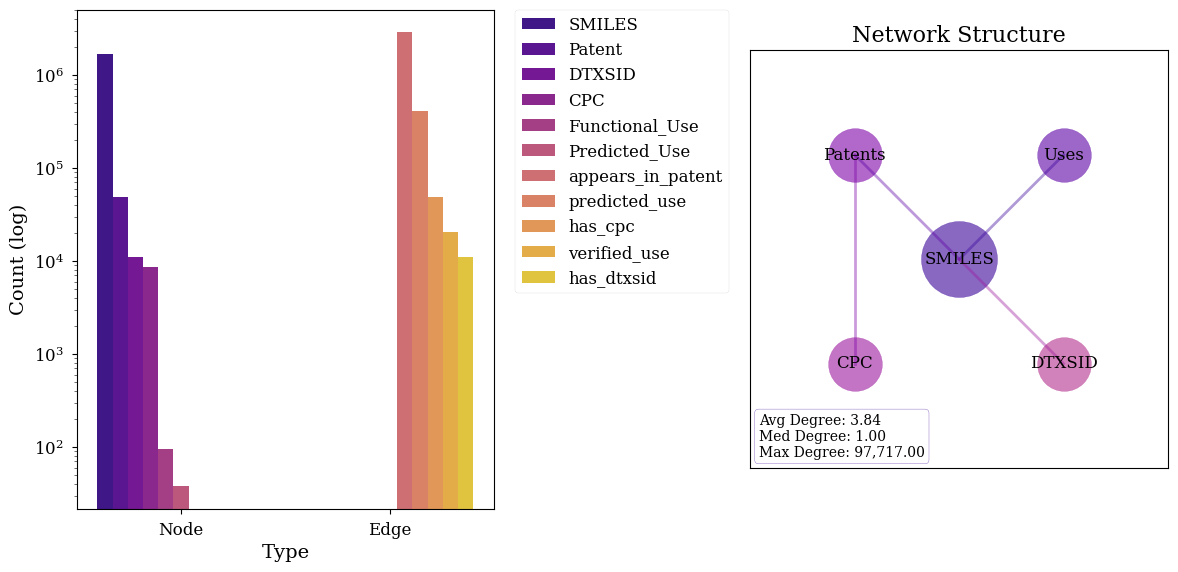

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def create_efficient_visualization():
    # Set style for publication
    plt.style.use('seaborn-v0_8-paper')
    plt.rcParams.update({
        'font.family': 'serif',
        'font.size': 14,
        'axes.titlesize': 16,
        'axes.labelsize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12,
    })
    
    # Updated data with correct statistics
    combined_data = {
        'Nodes': {
            'SMILES': 1686532,
            'Patent': 48823,
            'DTXSID': 10972,
            'CPC': 8619,
            'Functional_Use': 95,
            'Predicted_Use': 38
        },
        'Edges': {
            'appears_in_patent': 2879209,
            'predicted_use': 409999,
            'has_cpc': 48823,
            'verified_use': 20483,
            'has_dtxsid': 10972
        }
    }
    
    # Create a single figure with two subplots side by side
    fig = plt.figure(figsize=(12, 6))
    
    # Create subplot for the combined bar plot
    ax1 = plt.subplot(121)
    
    # Convert data to DataFrame for easier plotting
    df = pd.DataFrame({
        'Type': ['Node']*len(combined_data['Nodes']) + ['Edge']*len(combined_data['Edges']),
        'Name': list(combined_data['Nodes'].keys()) + list(combined_data['Edges'].keys()),
        'Count': list(combined_data['Nodes'].values()) + list(combined_data['Edges'].values())
    })
    
    # Create plasma color palette for all elements
    plasma_colors = sns.color_palette("plasma", n_colors=len(df))
    
    # Create grouped bar plot with plasma colors
    sns.barplot(data=df, x='Type', y='Count', hue='Name', ax=ax1, palette=plasma_colors)
    ax1.set_yscale('log')
    ax1.set_ylabel('Count (log)')
    ax1.tick_params(axis='both', labelsize=12)
    
    # Rotate legend labels for better readability
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    # Create network structure overview
    ax2 = plt.subplot(122)
    
    # Centered network visualization positions
    pos = {
        'SMILES': (0.5, 0.5),  # Center
        'Uses': (0.7, 0.7),    # Adjusted for better centering
        'Patents': (0.3, 0.7),
        'CPC': (0.3, 0.3),
        'DTXSID': (0.7, 0.3)
    }
    
    # Draw nodes with plasma colors
    for i, (node, (x, y)) in enumerate(pos.items()):
        size = 3000 if node == 'SMILES' else 1500
        ax2.scatter(x, y, s=size, alpha=0.6, color=plasma_colors[i])
        ax2.text(x, y, node, ha='center', va='center', fontsize=12)
    
    # Draw edges with plasma colors (lighter shades)
    for i, (start, end) in enumerate([
        ('SMILES', 'Uses'),
        ('SMILES', 'Patents'),
        ('Patents', 'CPC'),
        ('SMILES', 'DTXSID')
    ]):
        ax2.plot([pos[start][0], pos[end][0]], 
                [pos[start][1], pos[end][1]], 
                '-', color=plasma_colors[i], alpha=0.4, linewidth=2)
    
    # Set equal aspect ratio for better node spacing
    ax2.set_aspect('equal')
    
    # Adjust axis limits to center the visualization
    ax2.set_xlim(0.1, 0.9)
    ax2.set_ylim(0.1, 0.9)
    
    ax2.set_title('Network Structure')
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    # Add degree statistics as text box with updated values
    degree_stats = {
        'Avg Degree': 3.84,
        'Med Degree': 1.00,
        'Max Degree': 97717
    }
    stats_text = '\n'.join([f'{k}: {v:,.2f}' for k, v in degree_stats.items()])
    ax2.text(0.02, 0.02, stats_text, transform=ax2.transAxes, 
             verticalalignment='bottom', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, 
                      edgecolor=plasma_colors[0]))
    
    plt.tight_layout()
    plt.savefig('kg_efficient_summary.png', dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')

if __name__ == "__main__":
    create_efficient_visualization()

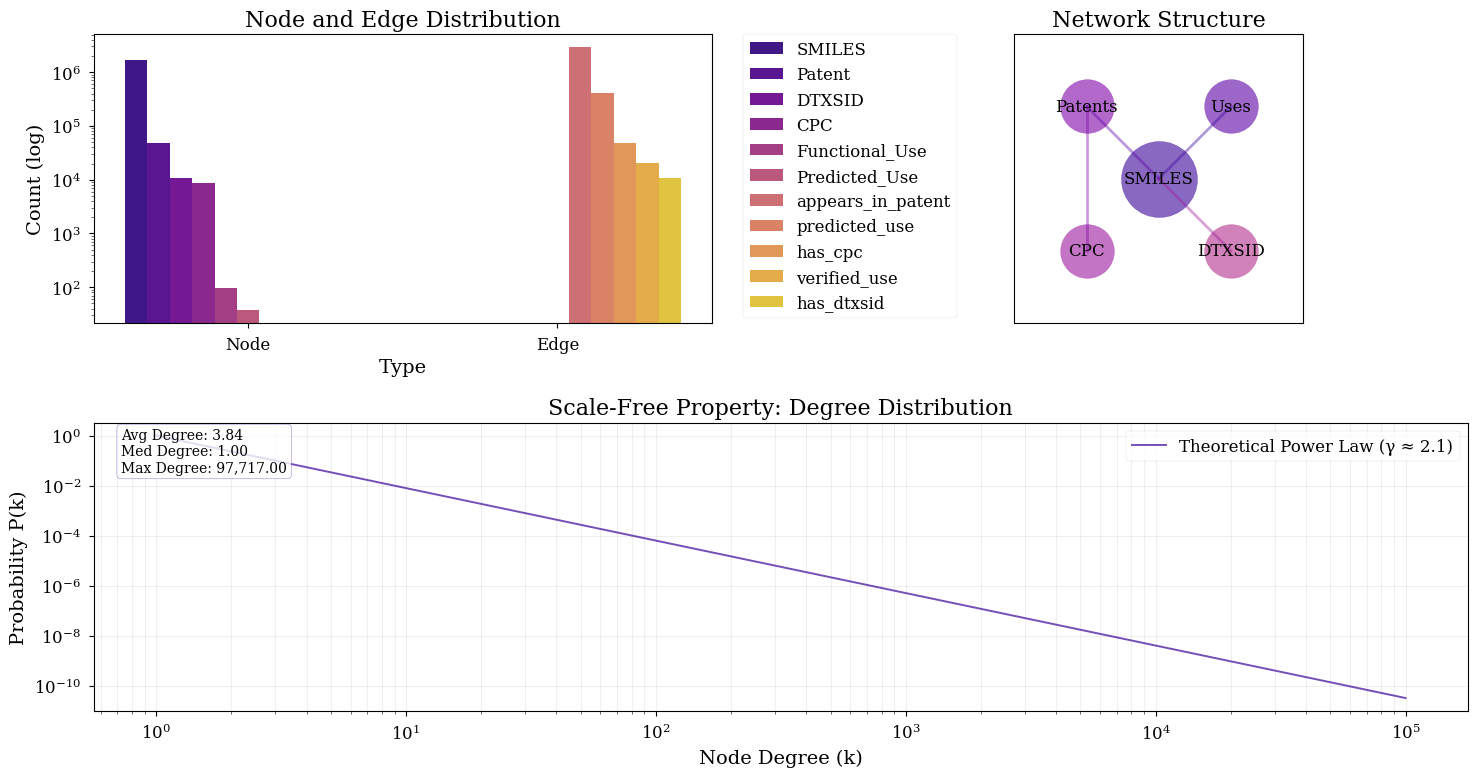

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec

def create_efficient_visualization():
    # Set style for publication
    plt.style.use('seaborn-v0_8-paper')
    plt.rcParams.update({
        'font.family': 'serif',
        'font.size': 14,
        'axes.titlesize': 16,
        'axes.labelsize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12,
    })
    
    # Create figure with GridSpec for 3 subplots
    fig = plt.figure(figsize=(15, 8))
    gs = GridSpec(2, 2)
    
    # Data
    combined_data = {
        'Nodes': {
            'SMILES': 1686532,
            'Patent': 48823,
            'DTXSID': 10972,
            'CPC': 8619,
            'Functional_Use': 95,
            'Predicted_Use': 38
        },
        'Edges': {
            'appears_in_patent': 2879209,
            'predicted_use': 409999,
            'has_cpc': 48823,
            'verified_use': 20483,
            'has_dtxsid': 10972
        }
    }
    
    # Plot 1: Distribution plot (top left)
    ax1 = fig.add_subplot(gs[0, 0])
    df = pd.DataFrame({
        'Type': ['Node']*len(combined_data['Nodes']) + ['Edge']*len(combined_data['Edges']),
        'Name': list(combined_data['Nodes'].keys()) + list(combined_data['Edges'].keys()),
        'Count': list(combined_data['Nodes'].values()) + list(combined_data['Edges'].values())
    })
    plasma_colors = sns.color_palette("plasma", n_colors=len(df))
    sns.barplot(data=df, x='Type', y='Count', hue='Name', ax=ax1, palette=plasma_colors)
    ax1.set_yscale('log')
    ax1.set_ylabel('Count (log)')
    ax1.tick_params(axis='both', labelsize=12)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax1.set_title('Node and Edge Distribution')
    
    # Plot 2: Network structure (top right)
    ax2 = fig.add_subplot(gs[0, 1])
    pos = {
        'SMILES': (0.5, 0.5),
        'Uses': (0.7, 0.7),
        'Patents': (0.3, 0.7),
        'CPC': (0.3, 0.3),
        'DTXSID': (0.7, 0.3)
    }
    
    for i, (node, (x, y)) in enumerate(pos.items()):
        size = 3000 if node == 'SMILES' else 1500
        ax2.scatter(x, y, s=size, alpha=0.6, color=plasma_colors[i])
        ax2.text(x, y, node, ha='center', va='center', fontsize=12)
    
    for i, (start, end) in enumerate([
        ('SMILES', 'Uses'),
        ('SMILES', 'Patents'),
        ('Patents', 'CPC'),
        ('SMILES', 'DTXSID')
    ]):
        ax2.plot([pos[start][0], pos[end][0]], 
                [pos[start][1], pos[end][1]], 
                '-', color=plasma_colors[i], alpha=0.4, linewidth=2)
    
    ax2.set_aspect('equal')
    ax2.set_xlim(0.1, 0.9)
    ax2.set_ylim(0.1, 0.9)
    ax2.set_title('Network Structure')
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    # Plot 3: Scale-free property demonstration (bottom spanning)
    ax3 = fig.add_subplot(gs[1, :])
    
    # Generate theoretical power-law distribution
    x = np.logspace(0, 5, 100)
    y = x**(-2.1)  # Power law with exponent -2.1 (typical for scale-free networks)
    
    ax3.loglog(x, y, '-', color=plasma_colors[0], alpha=0.7, 
               label='Theoretical Power Law (γ ≈ 2.1)')
    
    ax3.set_xlabel('Node Degree (k)')
    ax3.set_ylabel('Probability P(k)')
    ax3.set_title('Scale-Free Property: Degree Distribution')
    ax3.grid(True, which="both", ls="-", alpha=0.2)
    ax3.legend()
    
    # Add degree statistics
    degree_stats = {
        'Avg Degree': 3.84,
        'Med Degree': 1.00,
        'Max Degree': 97717
    }
    stats_text = '\n'.join([f'{k}: {v:,.2f}' for k, v in degree_stats.items()])
    ax3.text(0.02, 0.98, stats_text, transform=ax3.transAxes, 
             verticalalignment='top', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, 
                      edgecolor=plasma_colors[0]))
    
    plt.tight_layout()
    plt.savefig('kg_efficient_summary.png', dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')

if __name__ == "__main__":
    create_efficient_visualization()